<a href="https://colab.research.google.com/github/MikeManzi/multimodel-data-preprocessing/blob/main/Product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#  Install dependencies
!pip install pandas scikit-learn xgboost imbalanced-learn matplotlib seaborn --quiet

#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
import joblib

In [25]:
df = pd.read_csv("/content/merged_customer_data.csv")

print("Data Loaded Successfully!")
print(df.head())
print("\n Shape:", df.shape)

#  Basic Cleaning
print("\nMissing Values:\n", df.isnull().sum())



Data Loaded Successfully!
   customer_id_new social_media_platform  engagement_score  \
0              190               Twitter                82   
1              190               Twitter                82   
2              150              Facebook                96   
3              150              Facebook                96   
4              162               Twitter                89   

   purchase_interest_score review_sentiment  transaction_id  purchase_amount  \
0                      4.8          Neutral            1031              333   
1                      4.8          Neutral            1140              401   
2                      1.6         Positive            1042              389   
3                      1.6         Positive            1046              177   
4                      2.6         Positive            1079              101   

  purchase_date product_category  customer_rating  
0    2024-01-31        Groceries              3.8  
1    2024-05-19 

In [26]:
# Fill missing numeric values
df['customer_rating'] = df['customer_rating'].fillna(df['customer_rating'].median())

# Drop rows with missing target
df = df.dropna(subset=['product_category'])

# Map sentiment to numeric for feature engineering
sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['review_sentiment_score'] = df['review_sentiment'].map(sentiment_map)

# Extract month from purchase date
df['purchase_month'] = pd.to_datetime(df['purchase_date']).dt.month

# Behavioral features
df['avg_spend'] = df.groupby('customer_id_new')['purchase_amount'].transform('mean')
df['spend_ratio'] = df['purchase_amount'] / df['avg_spend']

# Purchase frequency
purchase_freq = df['customer_id_new'].value_counts().to_dict()
df['purchase_frequency'] = df['customer_id_new'].map(purchase_freq)


In [27]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['social_media_platform', 'review_sentiment'], drop_first=True)

# Drop unnecessary columns
df = df.drop(['transaction_id', 'purchase_date', 'customer_id_new'], axis=1)


In [28]:
X = df.drop('product_category', axis=1)
y = df['product_category']

from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42, stratify=y)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balance
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", X_train_bal.shape, "balanced classes.")


After SMOTE: (225, 15) balanced classes.


In [49]:

# HYPERPARAMETER TUNING - XGBOOST
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

print("\n Running Grid Search (this may take a few minutes)...")
grid_search.fit(X_train_bal, y_train_bal)
best_xgb = grid_search.best_estimator_

print("\n Best Parameters:")
print(grid_search.best_params_)
print("Best Cross-Validated F1:", round(grid_search.best_score_, 4))



 Running Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

 Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-Validated F1: 0.7595



Final Model Performance (XGBoost Tuned)
Accuracy: 0.7091
F1 Score: 0.7106

              precision    recall  f1-score   support

       Books       0.62      0.80      0.70        10
    Clothing       0.86      0.75      0.80         8
 Electronics       0.64      0.75      0.69        12
   Groceries       0.88      0.70      0.78        10
      Sports       0.69      0.60      0.64        15

    accuracy                           0.71        55
   macro avg       0.74      0.72      0.72        55
weighted avg       0.72      0.71      0.71        55



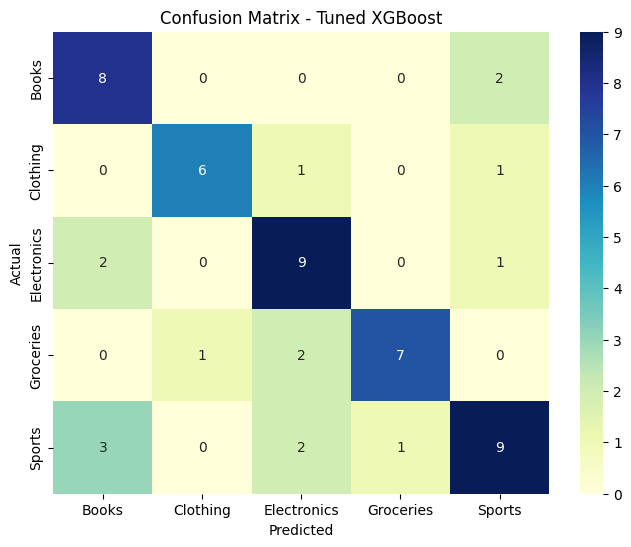

In [48]:
#Final Evaluation
y_pred = best_xgb.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nFinal Model Performance (XGBoost Tuned)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}\n")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_,
            cmap='YlGnBu')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<Figure size 1000x600 with 0 Axes>

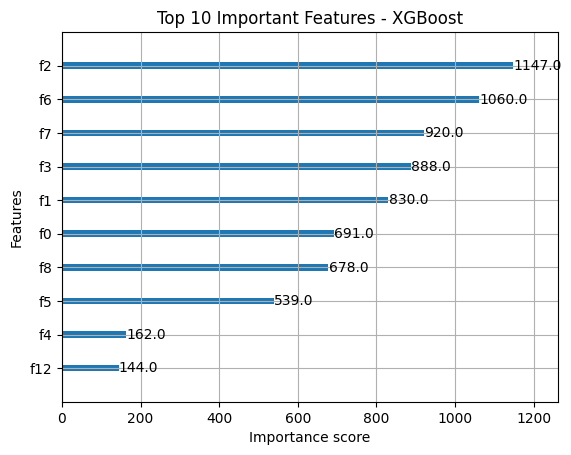

In [47]:
plt.figure(figsize=(10,6))
plot_importance(best_xgb, max_num_features=10)
plt.title("Top 10 Important Features - XGBoost")
plt.show()


In [46]:
sample = pd.DataFrame({
    'engagement_score': [88],
    'purchase_interest_score': [3.9],
    'review_sentiment_score': [2],
    'purchase_amount': [420],
    'customer_rating': [4.5],
    'purchase_month': [5],
    'avg_spend': [350],
    'spend_ratio': [1.2],
    'purchase_frequency': [5],
    'social_media_platform_Facebook': [0],
    'social_media_platform_LinkedIn': [0],
    'social_media_platform_TikTok': [1],
    'social_media_platform_Twitter': [0],
    'review_sentiment_Neutral': [0],
    'review_sentiment_Positive': [1]
})


In [52]:
sample = sample.reindex(columns=X.columns, fill_value=0)

sample_scaled = scaler.transform(sample)
pred = best_xgb.predict(sample_scaled)
pred_label = le_target.inverse_transform(pred)

print(f"Recommended Product Category for this user: {pred_label[0]}")


Recommended Product Category for this user: Clothing


In [57]:
joblib.dump(best_xgb, "/content/product_recommendation_xgb_model.pkl")
joblib.dump(scaler, "/content/product_recommendation_scaler.pkl")
joblib.dump(le_target, "/content/product_recommendation_target_encoder.pkl")

print("Model, scaler, and target encoder saved!")

Model, scaler, and target encoder saved!
